# Heat Transfer II
February 26th, 2025

Data analysis & Comsol post-processing by Alex Quemel, Rahil Shaik, Sneha Kancharla, and Ethan Mibu

### Pre-processing

In [130]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

In [131]:
data = {
    'Flow Rate (SCFM)': [1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4],
    'Thermistor #': [4, 5, 6, 4, 5, 6, 4, 5, 6, 4, 5, 6],
    'Temperature 1 (°C)': [115.8, 113.6, 111.7, 113.3, 110.8, 108.4, 112.0, 109.1, 106.3, 109.0, 106.8, 104.1],
    'Temperature 2 (°C)': [116.2, 114.8, 112.7, 116.0, 113.9, 111.1, 115.7, 113.2, 110.1, 115.1, 112.0, 108.5],
    'Temperature 3 (°C)': [None, None, None, 115.8, 113.4, 111.0, 114.7, 111.8, 108.7, None, None, None],
}

In [132]:
df = pd.DataFrame(data)
df["Avg Temp (°C)"] = df[["Temperature 1 (°C)", "Temperature 2 (°C)", "Temperature 3 (°C)"]].mean(axis=1)
df["Avg Temp (K)"] = df["Avg Temp (°C)"] + 273.15

In [133]:
def get_positions(thermistor_number):
    if thermistor_number == 6:
        return .0125
    elif thermistor_number == 5:
        return .0125 + .0254
    elif thermistor_number == 4:
        return .0125 + .0254 + .0254
    else:
        return None
    
df["positions (m)"] = df["Thermistor #"].apply(get_positions)

## Question 2
### From an appropriate plot of your thermistor data, obtain the convective heat-transfer coefficient at the end of the rod, h, for all air flow rates. Fit your data utilizing the method you determine most appropriate to extrapolate the temperature and its gradient at the brass-rod face.


Our goal should be to plot temperature readings across the position and extrapolate the line to the ends of the rod. We will use this line to find a linear expression for T(z)

In [134]:
df

,Flow Rate (SCFM),Thermistor #,Temperature 1 (°C),Temperature 2 (°C),Temperature 3 (°C),Avg Temp (°C),Avg Temp (K),positions (m)
0,1,4,115.8,116.2,NaN,116.000000,389.150000,0.0633
1,1,5,113.6,114.8,NaN,114.200000,387.350000,0.0379
2,1,6,111.7,112.7,NaN,112.200000,385.350000,0.0125
3,2,4,113.3,116.0,115.8,115.033333,388.183333,0.0633
4,2,5,110.8,113.9,113.4,112.700000,385.850000,0.0379
5,2,6,108.4,111.1,111.0,110.166667,383.316667,0.0125
6,3,4,112.0,115.7,114.7,114.133333,387.283333,0.0633
7,3,5,109.1,113.2,111.8,111.366667,384.516667,0.0379
8,3,6,106.3,110.1,108.7,108.366667,381.516667,0.0125
9,4,4,109.0,115.1,NaN,112.050000,385.200000,0.0633


In [135]:
df_1 = df[df["Flow Rate (SCFM)"] == 1]
df_2 = df[df["Flow Rate (SCFM)"] == 2]
df_3 = df[df["Flow Rate (SCFM)"] == 3]
df_4 = df[df["Flow Rate (SCFM)"] == 4]

Text(0.5, 1.0, 'Temperature readings down brass rod')

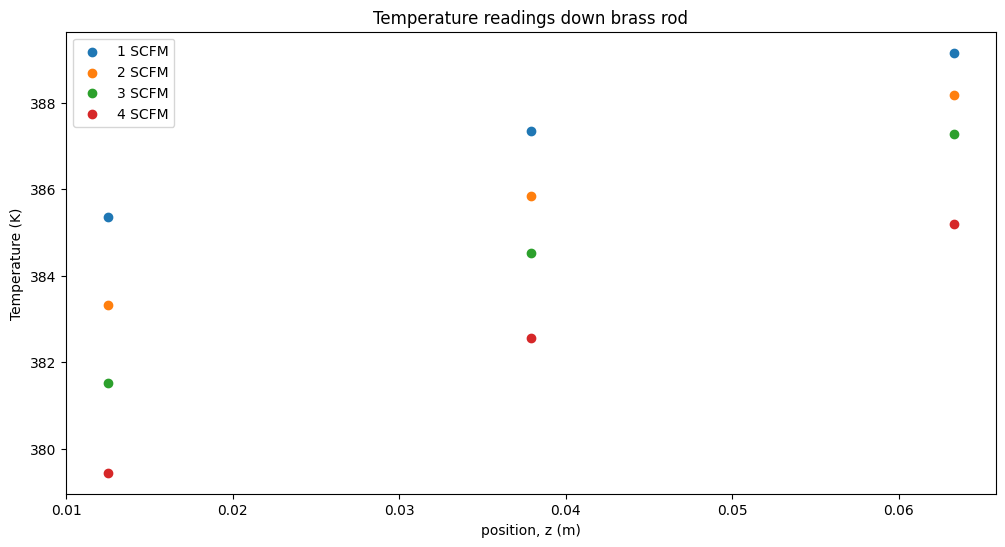

In [136]:
plt.figure(figsize=(12,6))
plt.scatter(df_1["positions (m)"], df_1["Avg Temp (K)"], label = "1 SCFM")
plt.scatter(df_2["positions (m)"], df_2["Avg Temp (K)"], label = "2 SCFM")
plt.scatter(df_3["positions (m)"], df_3["Avg Temp (K)"], label = "3 SCFM")
plt.scatter(df_4["positions (m)"], df_4["Avg Temp (K)"], label = "4 SCFM")
plt.legend()
plt.xlabel("position, z (m)")
plt.ylabel("Temperature (K)")
plt.title("Temperature readings down brass rod")

Now, that we have this plot, lets find an expression that defines the temperature across Z. Theoretically, at z = 0, the temperature should be the same as the heater, any discrepancy will be defined as a bias


$$q_s = h\Delta T$$

$$q = -k\nabla T$$

$$h = \frac{-k_{brass}(\nabla T)}{T_{surface}-T_{air}}$$

We are only looking at the axial direction right now, so we can simplify this expression to 

$$h = \frac{-k_{brass}(\frac{dT}{dz})}{T_{surface}-T_{air}}$$

In [137]:
rod_length = 0.081 # m
heater_input = 133 + 273.15 # K
k_brass = 120 # W/mK

In [138]:
slope_1, intercept_1, _, _, _ = stats.linregress(df_1["positions (m)"], df_1["Avg Temp (K)"])

slope_2, intercept_2, _, _, _ = stats.linregress(df_2["positions (m)"], df_2["Avg Temp (K)"])

slope_3, intercept_3, _, _, _ = stats.linregress(df_3["positions (m)"], df_3["Avg Temp (K)"])

slope_4, intercept_4, _, _, _ = stats.linregress(df_4["positions (m)"], df_4["Avg Temp (K)"])

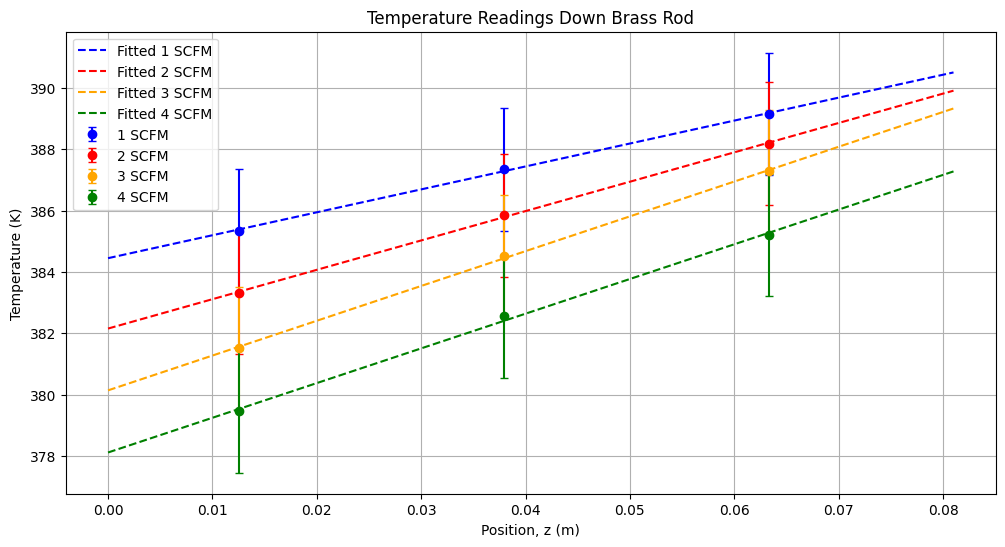

In [139]:
plt.figure(figsize=(12,6))

error_1 = np.full_like(df_1["Avg Temp (K)"], 2)  # Replace with actual std deviation
error_2 = np.full_like(df_2["Avg Temp (K)"], 2)  
error_3 = np.full_like(df_3["Avg Temp (K)"], 2)  
error_4 = np.full_like(df_4["Avg Temp (K)"], 2)  

# Raw data with error bars
plt.errorbar(df_1["positions (m)"], df_1["Avg Temp (K)"], yerr=error_1, fmt='o', label="1 SCFM", capsize=3, color = "blue")
plt.errorbar(df_2["positions (m)"], df_2["Avg Temp (K)"], yerr=error_2, fmt='o', label="2 SCFM", capsize=3, color = "red")
plt.errorbar(df_3["positions (m)"], df_3["Avg Temp (K)"], yerr=error_3, fmt='o', label="3 SCFM", capsize=3, color = "orange")
plt.errorbar(df_4["positions (m)"], df_4["Avg Temp (K)"], yerr=error_4, fmt='o', label="4 SCFM", capsize=3, color = "green")

plt.xlabel("Position, z (m)")
plt.ylabel("Temperature (K)")
plt.title("Temperature Readings Down Brass Rod")

positions = np.linspace(0, rod_length, 50)

# Fit lines
plt.plot(positions, [pos * slope_1 + intercept_1 for pos in positions], label="Fitted 1 SCFM", linestyle="--", color = "blue")
plt.plot(positions, [pos * slope_2 + intercept_2 for pos in positions], label="Fitted 2 SCFM", linestyle="--", color = "red")
plt.plot(positions, [pos * slope_3 + intercept_3 for pos in positions], label="Fitted 3 SCFM", linestyle="--", color = "orange")
plt.plot(positions, [pos * slope_4 + intercept_4 for pos in positions], label="Fitted 4 SCFM", linestyle="--", color = "green")

# Heater input temperature line
# plt.axhline(y=133 + 273.15, linestyle="--", label="Heater Input Temperature", color="black")

plt.legend()
plt.grid(True)
plt.show()


The end of each plot line should approach 406 K heating input temperature but it is a bit off, so there is heat loss at the heater-brass interface. Let's compute that loss.

In [140]:
bias_1 = heater_input - (slope_1 * rod_length + intercept_1)
bias_2 = heater_input - (slope_2 * rod_length + intercept_2)
bias_3 = heater_input - (slope_3 * rod_length + intercept_3)
bias_4 = heater_input - (slope_4 * rod_length + intercept_4)

In [141]:
print("Bias for 1 SCFM:", bias_1, "K")
print("Bias for 2 SCFM:", bias_2, "K")
print("Bias for 3 SCFM:", bias_3, "K")
print("Bias for 4 SCFM:", bias_4, "K")

Bias for 1 SCFM: 15.642650918635127 K
Bias for 2 SCFM: 16.237664041994776 K
Bias for 3 SCFM: 16.818525809273865 K
Bias for 4 SCFM: 18.871555118110166 K


Using this bias and the slope were able to extract from the linear fit line, we can define expressions for dT/dz for each flow rate, enabling us to compute each h value

In [142]:
def pred_h_1(z):
    return -k_brass * slope_1 * z + intercept_1 

def pred_h_2(z):
    return -k_brass * slope_2 * z + intercept_2

def pred_h_3(z):
    return -k_brass * slope_3 * z + intercept_3

def pred_h_4(z):
    return -k_brass * slope_4 * z + intercept_4

In [145]:
df_1["h W/m^2 K"] = df_1["positions (m)"].apply(pred_h_1)
df_2["h W/m^2 K"] = df_2["positions (m)"].apply(pred_h_2)
df_3["h W/m^2 K"] = df_3["positions (m)"].apply(pred_h_3)
df_4["h W/m^2 K"] = df_4["positions (m)"].apply(pred_h_4)

### Via extrapolation, the temperature at the brass rod faces are below as:

In [146]:
print("1 SCFM impinging jet face temperature", intercept_1, "K")
print("1 SCFM heater face temperature", slope_1 * rod_length + intercept_1, "K")

print("2 SCFM impinging jet face temperature", intercept_2, "K")
print("2 SCFM heater face temperature", slope_2 * rod_length + intercept_2, "K")

print("3 SCFM impinging jet face temperature", intercept_3, "K")
print("3 SCFM heater face temperature", slope_3 * rod_length + intercept_3, "K")

print("4 SCFM impinging jet face temperature", intercept_4, "K")
print("4 SCFM heater face temperature", slope_4 * rod_length + intercept_4, "K")


1 SCFM impinging jet face temperature 384.44829396325457 K
1 SCFM heater face temperature 390.50734908136485 K
2 SCFM impinging jet face temperature 382.15249343832016 K
2 SCFM heater face temperature 389.9123359580052 K
3 SCFM impinging jet face temperature 380.1365923009624 K
3 SCFM heater face temperature 389.3314741907261 K
4 SCFM impinging jet face temperature 378.11013779527565 K
4 SCFM heater face temperature 387.2784448818898 K


## Question 3
$$\textbf{Calculate the axial heat flux leaving the brass-rod face. Estimate the overall radial heat-transfer coefficient, 
U, between the brass rod and the surrounding air. }$$

You must consider
what heat-transfer resistances exist between the rod and the air. How does the magnitude
of your estimated U compare to the values of heater power input and h measured at the
rod face? What can you say about the energy balance of this system? Identify the sources
of heat loss. When estimating the axial heat flux, what is the most appropriate value for
the length of the cylinder (should you include or exclude the section with the heater)?